# Trajectory Inference with PAGA or Palantir

Diffusion maps were introduced by Ronald Coifman and Stephane Lafon, and the underlying idea is to assume that the data are samples from a diffusion process.

Palantir is an algorithm to align cells along differentiation trajectories. Palantir models differentiation as a stochastic process where stem cells differentiate to terminally differentiated cells by a series of steps through a low dimensional phenotypic manifold. Palantir effectively captures the continuity in cell states and the stochasticity in cell fate determination.

Note that both methods require the input of cells in their initial state, and we will introduce other methods that do not require the input of artificial information, such as pyVIA, in subsequent analyses.


## Preprocess data

As an example, we apply differential kinetic analysis to dentate gyrus neurogenesis, which comprises multiple heterogeneous subpopulations.

In [1]:
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import omicverse as ov
ov.plot_set()

Global seed set to 0



   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.9, Tutorials: https://omicverse.readthedocs.io/


In [2]:
import scvelo as scv
adata=scv.datasets.dentategyrus()
adata

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [3]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,)
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)

Begin robust gene identification
After filtration, 13264/13913 genes are kept. Among 13264 genes, 13189 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Malat1', 'Ptgds', 'Hbb-bt']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells. In our experience, often a rough estimate of the number of PCs does fine.

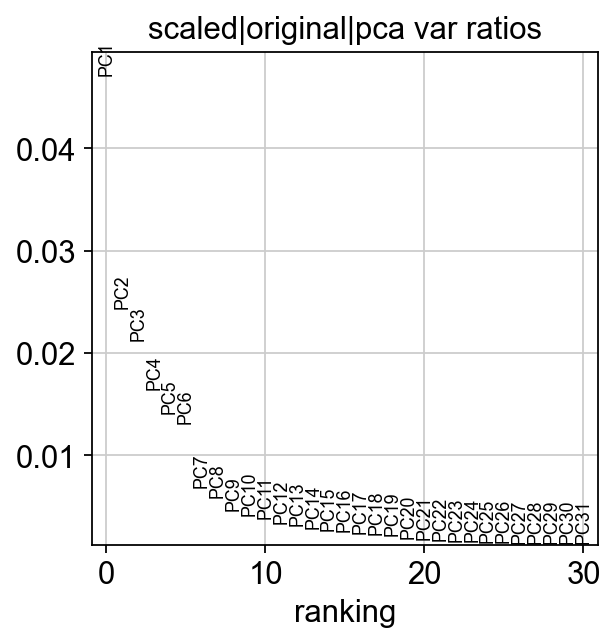

In [4]:
ov.utils.plot_pca_variance_ratio(adata)

## Trajectory inference with diffusion map

Here, we used `ov.single.TrajInfer` to construct a Trajectory Inference object.

In [5]:
Traj=ov.single.TrajInfer(adata,basis='X_umap',use_rep='scaled|original|X_pca',n_comps=50)
Traj.set_origin_cells('nIPC')

In [6]:
Traj.inference(method='diffusion_map')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9997221  0.99916786 0.9990551  0.99901944 0.99856067
     0.9955311  0.9947327  0.9926525  0.9906649  0.97991765 0.97849923
     0.9777416  0.97599846 0.9694986 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:06)
computing Diffusion

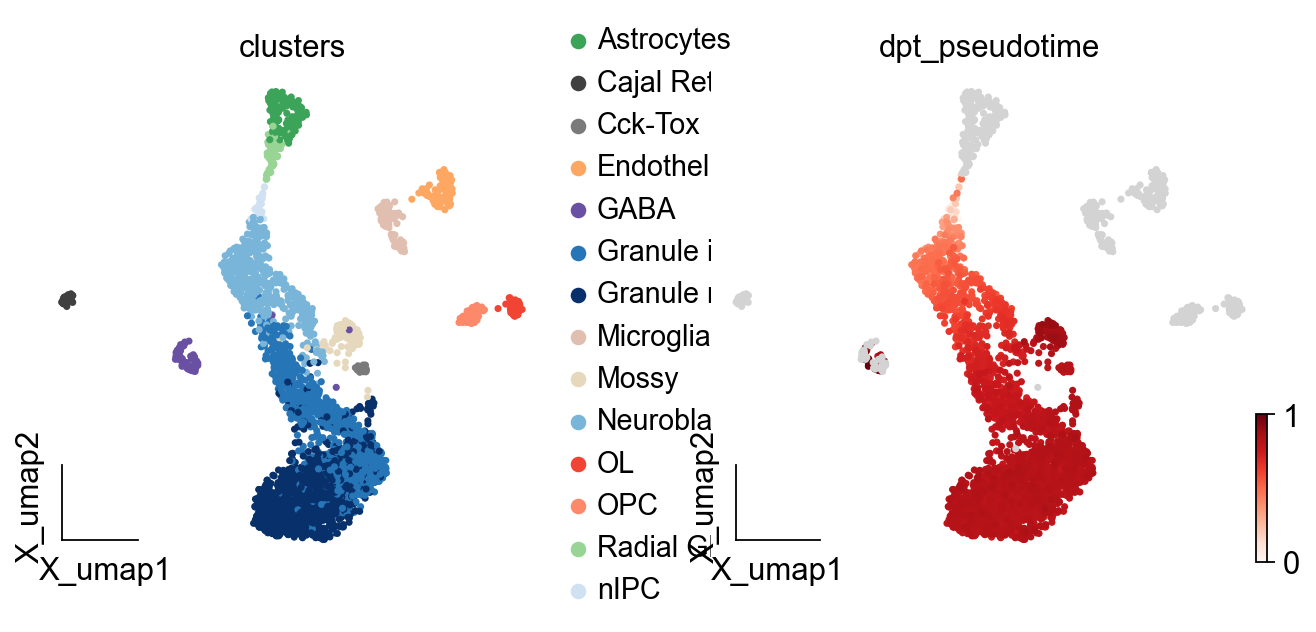

In [7]:
ov.utils.embedding(adata,basis='X_umap',
                   color=['clusters','dpt_pseudotime'],
                   frameon='small',cmap='Reds')

PAGA graph abstraction has benchmarked as top-performing method for trajectory inference. It provides a graph-like map of the data topology with weighted edges corresponding to the connectivity between two clusters. 

Here, PAGA is extended by neighbor directionality.

In [8]:
ov.utils.cal_paga(adata,use_time_prior='dpt_pseudotime',vkey='paga',
                 groups='clusters')

running PAGA using priors: ['dpt_pseudotime']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


<AxesSubplot: title={'center': 'PAGA LTNN-graph'}>

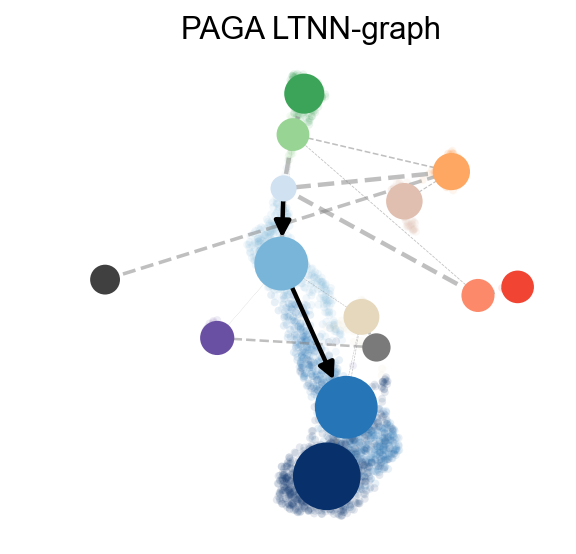

In [9]:
ov.utils.plot_paga(adata,basis='umap', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)

## Trajectory inference with Slingshot

Provides functions for inferring continuous, branching lineage structures in low-dimensional data. Slingshot was designed to model developmental trajectories in single-cell RNA sequencing data and serve as a component in an analysis pipeline after dimensionality reduction and clustering. It is flexible enough to handle arbitrarily many branching events and allows for the incorporation of prior knowledge through supervised graph construction.

In [6]:
Traj=ov.single.TrajInfer(adata,basis='X_umap',use_rep='scaled|original|X_pca',n_comps=50)
Traj.set_origin_cells('nIPC')
#Traj.set_terminal_cells(["Granule mature","OL","Astrocytes"])

If you only need the proposed timing and not the lineage of the process, then you can leave the debug_axes parameter unset.

In [7]:
Traj.inference(method='slingshot',num_epochs=1)

Lineages: [Lineage[13, 9, 5, 2, 8], Lineage[13, 9, 5, 2, 7, 3], Lineage[13, 9, 5, 4, 1], Lineage[13, 9, 5, 6, 11, 10], Lineage[13, 12, 0]]


  0%|          | 0/1 [00:00<?, ?it/s]

Reversing from leaf to root
Averaging branch @2 with lineages: [0, 1] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f1417bbddc0>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f1417bbdbe0>]
Averaging branch @5 with lineages: [0, 1, 2, 3] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f1417bbd790>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f1417bbdd30>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f1417bbdd90>]
Averaging branch @13 with lineages: [0, 1, 2, 3, 4] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f1417ccdd00>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f1417bbdd60>]
Shrinking branch @13 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f1417ccdd00>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f1417bbdd60>]
Shrinking branch @5 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f1417bbd790>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f1417bbdd30>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f1417bbdd90>]
Shrinking branch @2 with curves: [<pcu

else, you can set `debug_axes` to visualize the lineage

Lineages: [Lineage[13, 9, 5, 2, 8], Lineage[13, 9, 5, 2, 7, 3], Lineage[13, 9, 5, 4, 1], Lineage[13, 9, 5, 6, 11, 10], Lineage[13, 12, 0]]


  0%|          | 0/1 [00:00<?, ?it/s]

Reversing from leaf to root
Averaging branch @2 with lineages: [0, 1] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f13b91defa0>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f13b9272250>]
Averaging branch @5 with lineages: [0, 1, 2, 3] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f13b8ef0430>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f13b91ed040>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f13b91defd0>]
Averaging branch @13 with lineages: [0, 1, 2, 3, 4] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f13b91ed0a0>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f13b8ef0850>]
Shrinking branch @13 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f13b91ed0a0>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f13b8ef0850>]
Shrinking branch @5 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f13b8ef0430>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f13b91ed040>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f13b91defd0>]
Shrinking branch @2 with curves: [<pcu

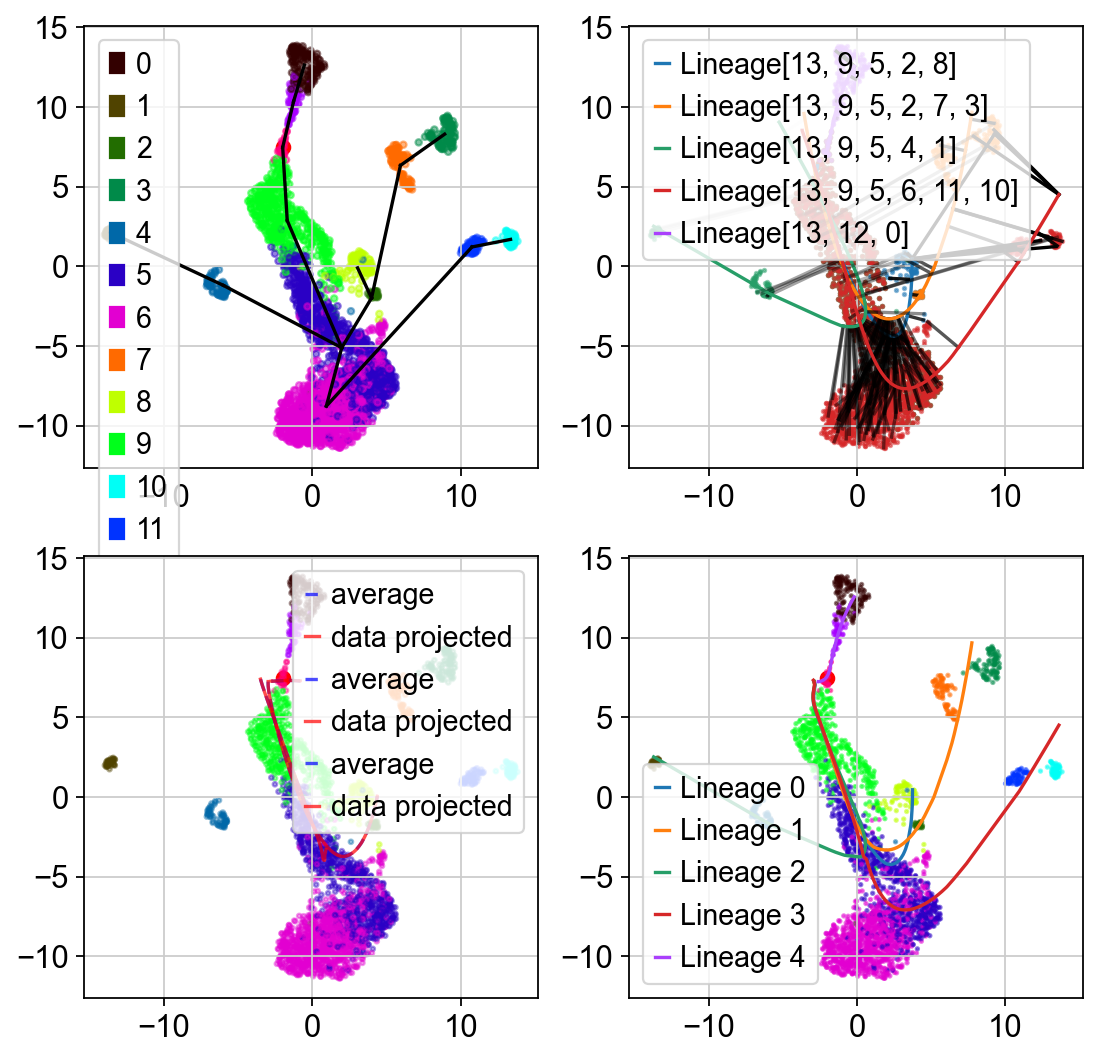

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
Traj.inference(method='slingshot',num_epochs=1,debug_axes=axes)

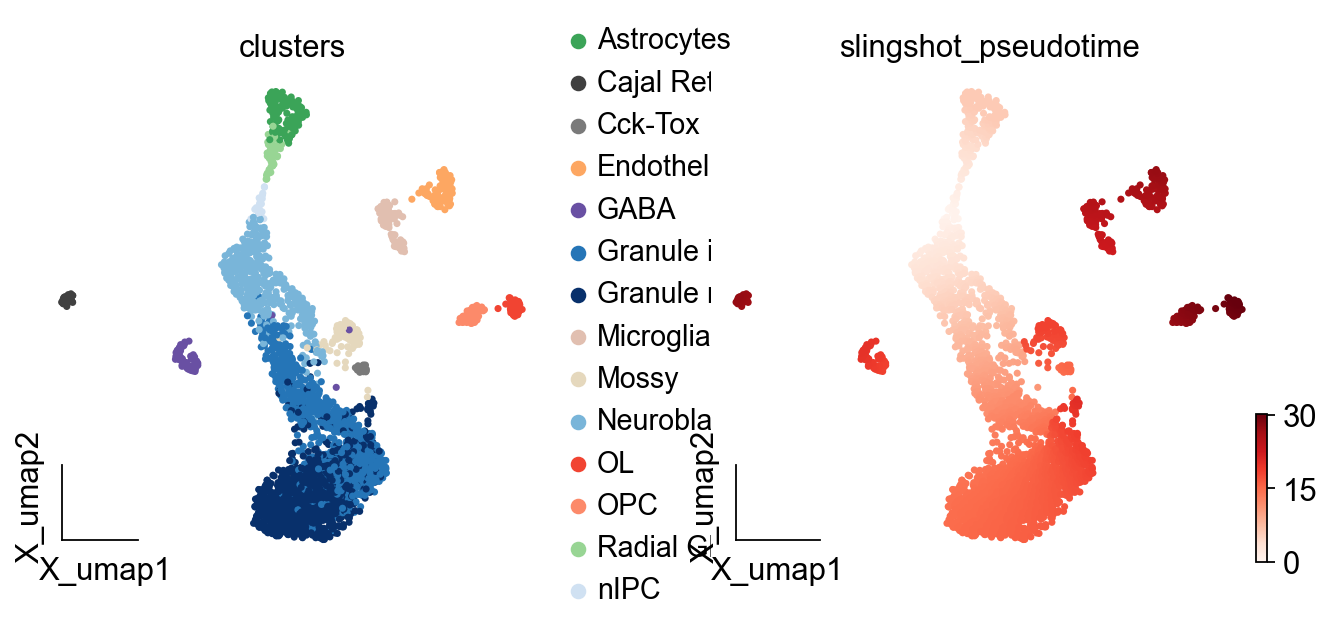

In [8]:
ov.utils.embedding(adata,basis='X_umap',
                   color=['clusters','slingshot_pseudotime'],
                   frameon='small',cmap='Reds')

In [9]:
sc.pp.neighbors(adata,use_rep='scaled|original|X_pca')
ov.utils.cal_paga(adata,use_time_prior='slingshot_pseudotime',vkey='paga',
                 groups='clusters')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA using priors: ['slingshot_pseudotime']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


<AxesSubplot: title={'center': 'PAGA Slingshot-graph'}>

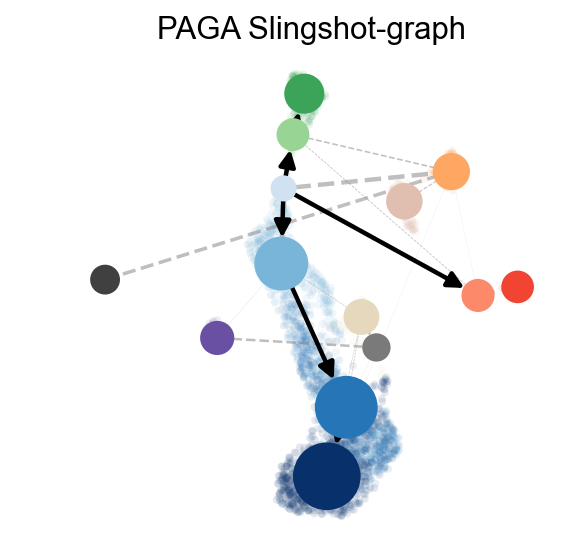

In [10]:
ov.utils.plot_paga(adata,basis='umap', size=50, alpha=.1,title='PAGA Slingshot-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)

## Trajectory inference with Palantir

Palantir can be run by specifying an approxiate early cell.

Palantir can automatically determine the terminal states as well. In this dataset, we know the terminal states and we will set them using the terminal_states parameter

Here, we used `ov.single.TrajInfer` to construct a Trajectory Inference object.

In [10]:
Traj=ov.single.TrajInfer(adata,basis='X_umap',use_rep='scaled|original|X_pca',n_comps=50)
Traj.set_origin_cells('nIPC')
Traj.set_terminal_cells(["Granule mature","OL","Astrocytes"])

In [11]:
Traj.inference(method='palantir',num_waypoints=500)

Time for shortest paths: 0.28744163910547893 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9998
Correlation at iteration 2: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Palantir results can be visualized on the tSNE or UMAP using the plot_palantir_results function

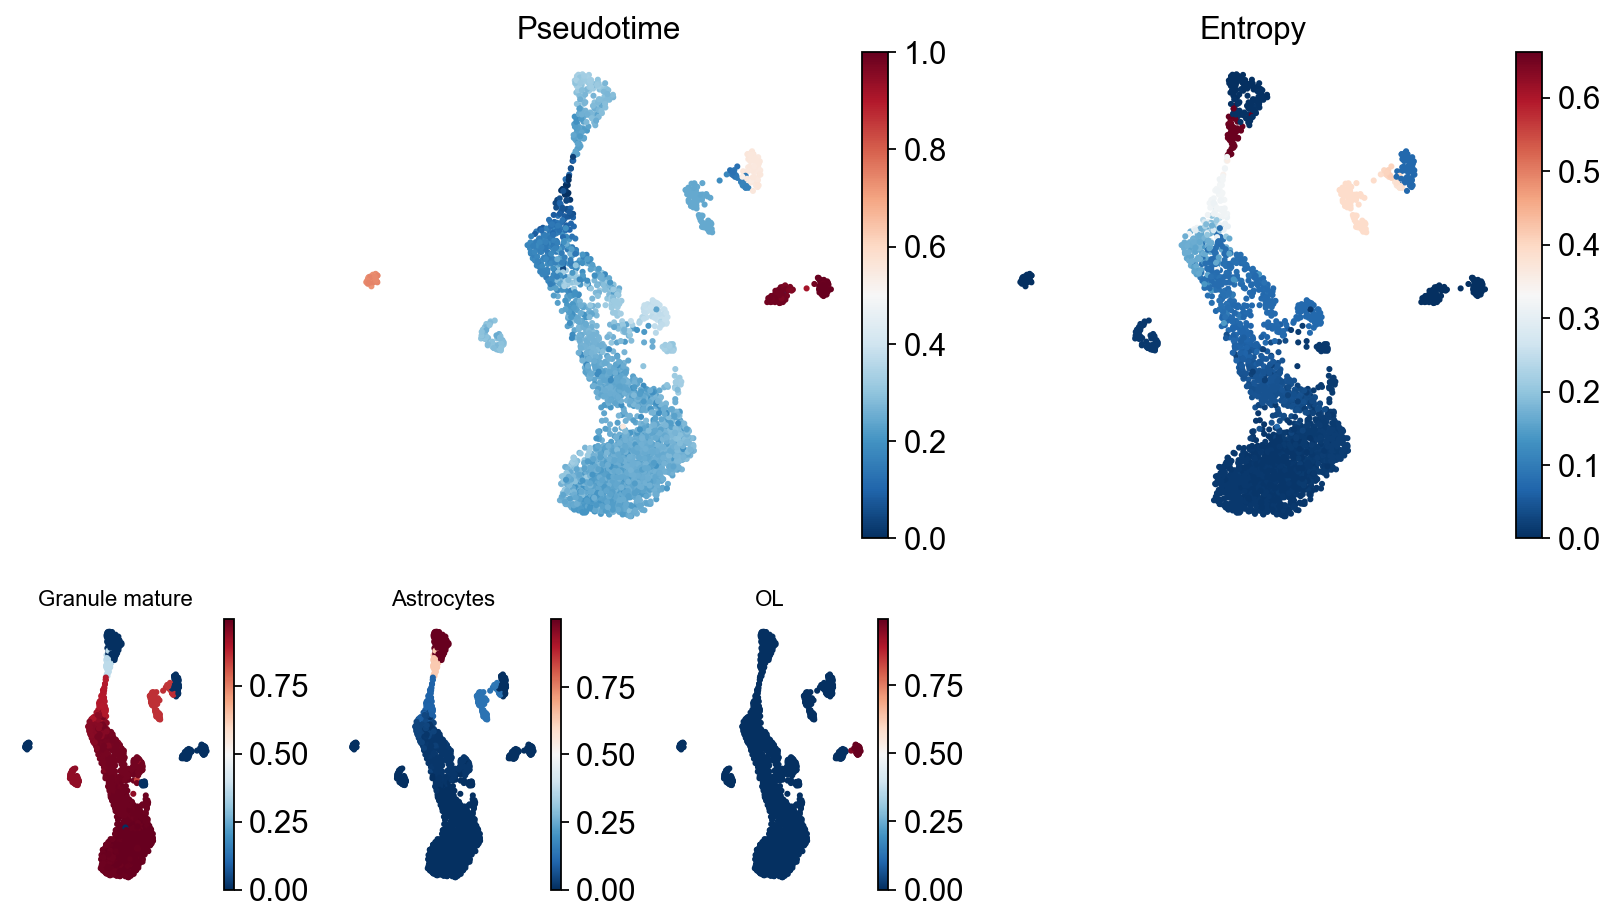

In [12]:
Traj.palantir_plot_pseudotime(embedding_basis='X_umap',cmap='RdBu_r',s=3)

Once the cells are selected, it's often helpful to visualize the selection on the pseudotime trajectory to ensure we've isolated the correct cells for our specific trend. We can do this using the plot_branch_selection function:

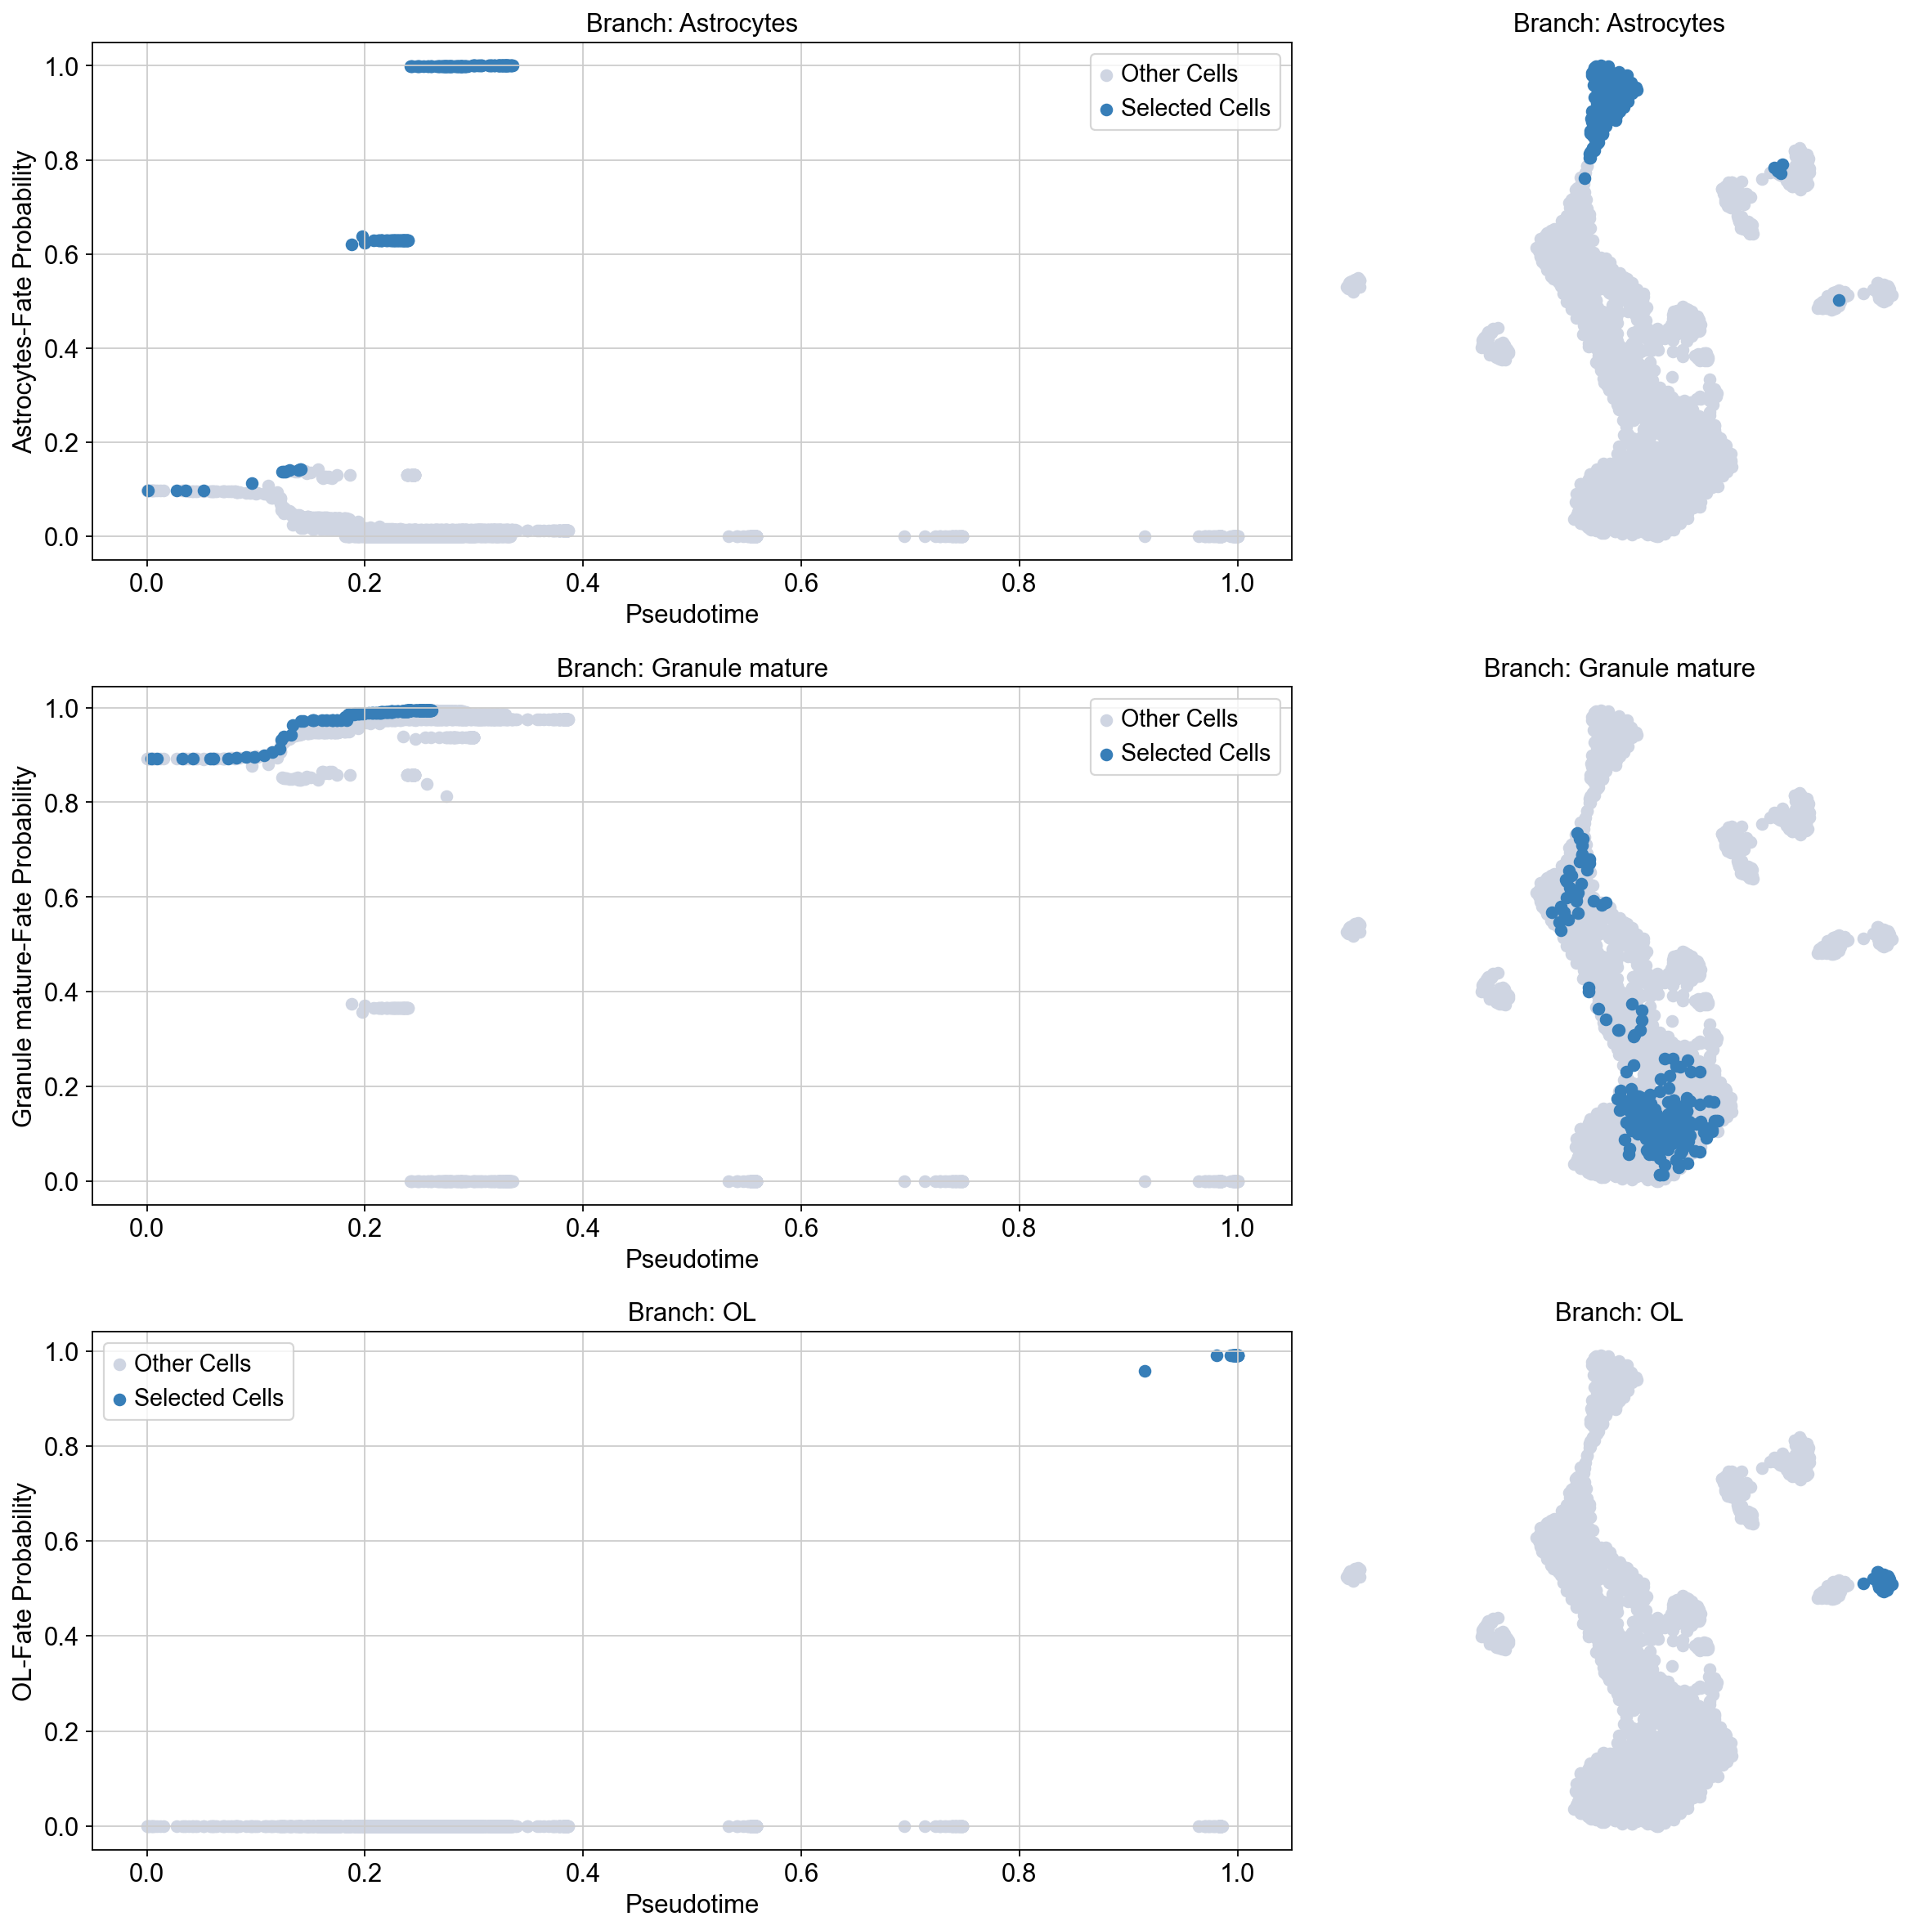

In [13]:
Traj.palantir_cal_branch(eps=0)

[2023-11-17 04:20:22,823] [INFO    ] Using covariance function Matern52(ls=1.8777667989311575).
[2023-11-17 04:20:22,824] [INFO    ] Computing 50 landmarks with k-means clustering.


<AxesSubplot: title={'center': 'Branch: Granule mature'}, xlabel='UMAP1', ylabel='UMAP2'>

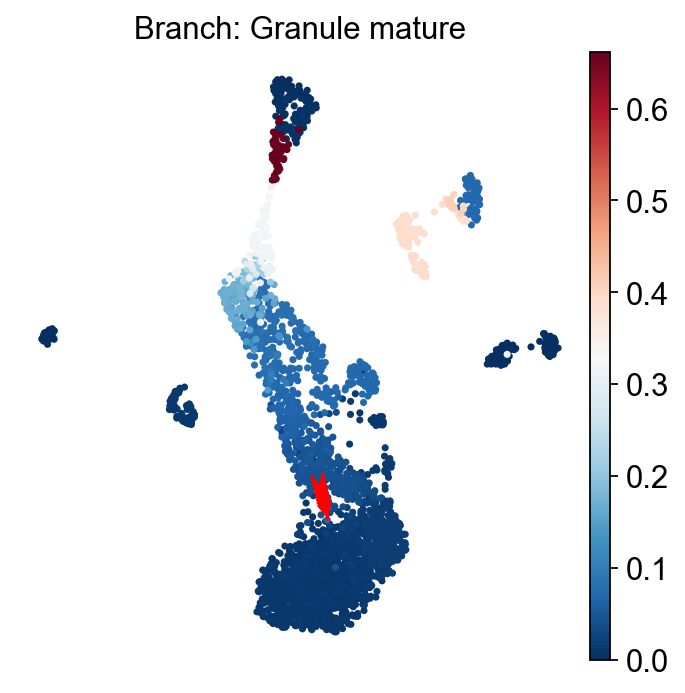

In [24]:
ov.palantir.plot.plot_trajectory(adata, "Granule mature",
                                cell_color="palantir_entropy",
                                n_arrows=10,
                                color="red",
                                scanpy_kwargs=dict(cmap="RdBu_r"),
                                )

Palantir uses Mellon Function Estimator to determine the gene expression trends along different lineages. The marker trends can be determined using the following snippet. This computes the trends for all lineages. A subset of lineages can be used using the lineages parameter.

In [29]:
gene_trends = Traj.palantir_cal_gene_trends(
    layers="MAGIC_imputed_data",
)

Granule mature
[2023-11-17 04:21:20,883] [INFO    ] Using covariance function Matern52(ls=1.0).
Astrocytes
[2023-11-17 04:21:21,286] [INFO    ] Using covariance function Matern52(ls=1.0).
OL
[2023-11-17 04:21:21,691] [INFO    ] Using covariance function Matern52(ls=1.0).


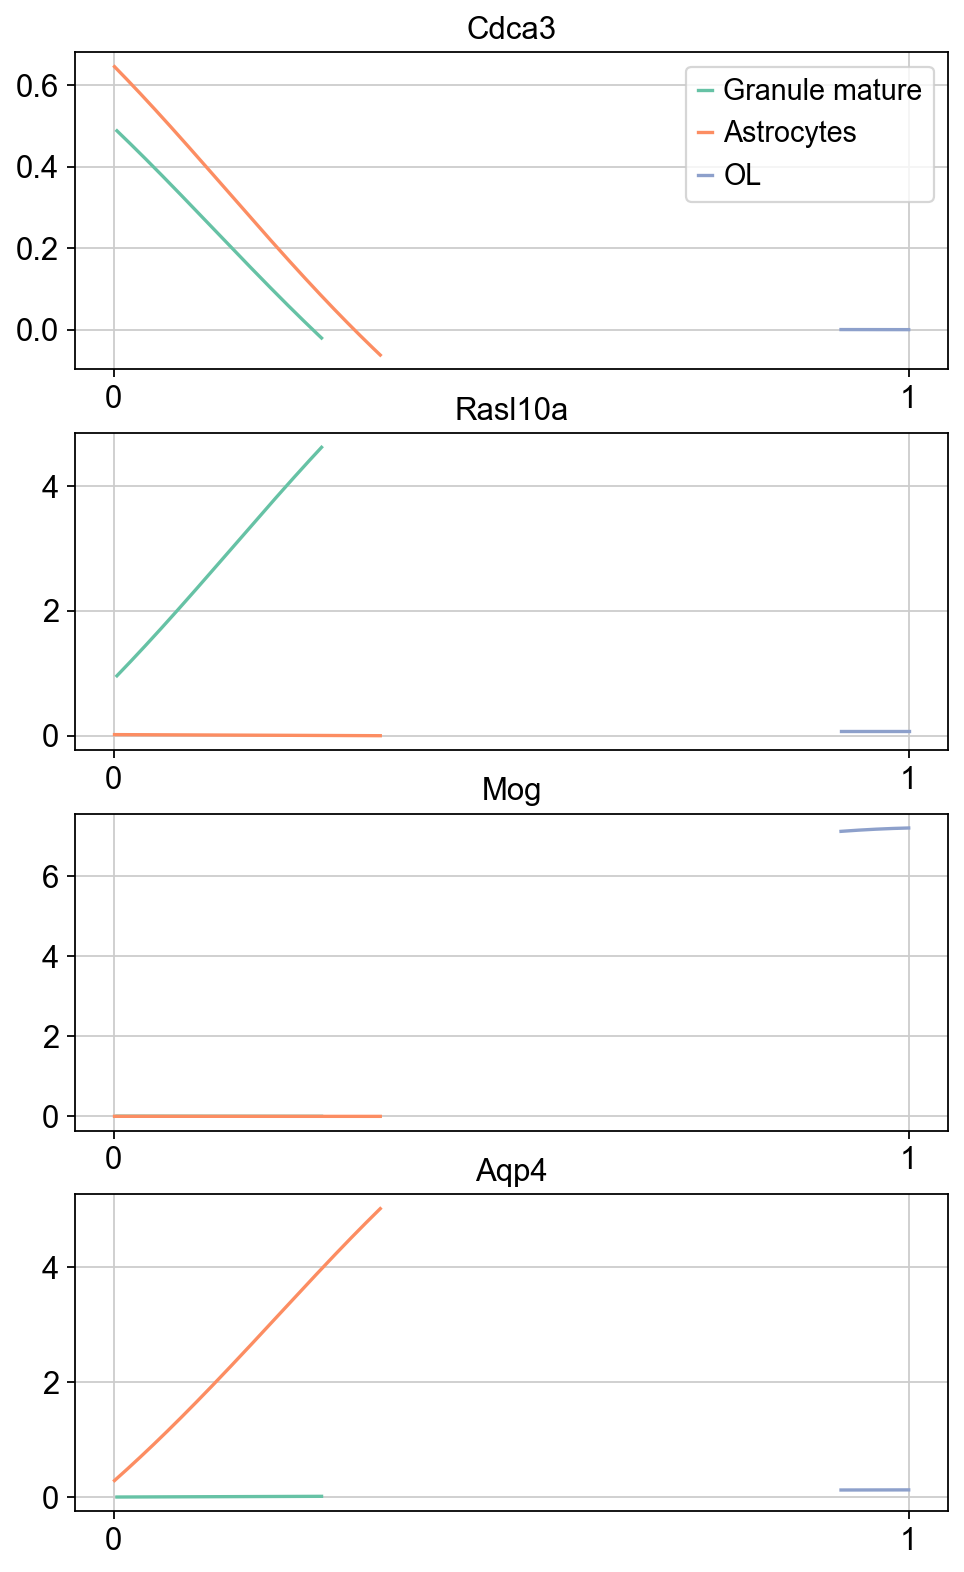

In [32]:
genes = ['Cdca3','Rasl10a','Mog','Aqp4']
Traj.palantir_plot_gene_trends(genes)
plt.show()

We can also use paga to visualize the cell stages

In [34]:
ov.utils.cal_paga(adata,use_time_prior='palantir_pseudotime',vkey='paga',
                 groups='clusters')

running PAGA using priors: ['palantir_pseudotime']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


<AxesSubplot: title={'center': 'PAGA LTNN-graph'}>

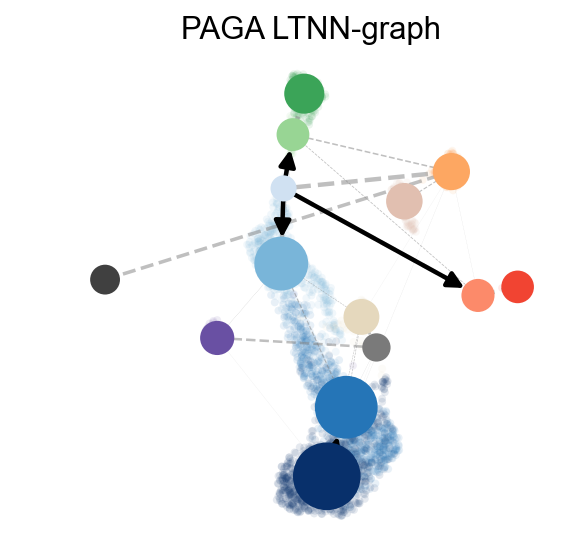

In [35]:
ov.utils.plot_paga(adata,basis='umap', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)